# Corresponding

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy
import scipy.signal
import matplotlib.pyplot
import matplotlib.cm
import pathlib
import PIL.Image

In [3]:
matplotlib.pyplot.rcParams.update({'font.size': 22})

(288, 384)


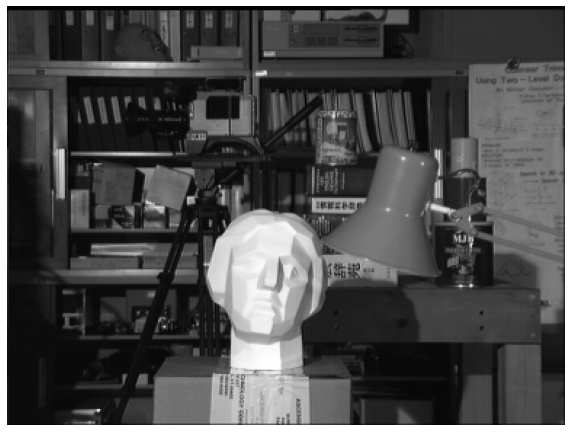

In [4]:
# Open image and convert to grayscale
path: pathlib.Path = pathlib.Path('./images/tsukuba/scene1.row3.col1.ppm')
img = numpy.array(PIL.Image.open(str(path)).convert('L'))
print(img.shape)

figure = matplotlib.pyplot.figure(figsize=(10, 10))



matplotlib.pyplot.axis('off')
# matplotlib.pyplot.title('Image I')
_ = matplotlib.pyplot.imshow(img, cmap=matplotlib.cm.gray)

## Write function to detect interst points

In [5]:
# import eagle.points.response

# def find_interest_points(
#     img: numpy.ndarray, 
#     size_neigh: int, 
#     epsilon: float
# ) -> numpy.ndarray:
#     r = eagle.points.response.kitchen_rosenfeld(img)
#     rp = eagle.points.response.remove_non_maxima(r, size_neigh)
#     points = eagle.points.response.select_with_threshold(rp, epsilon)
#     return points

## Find interset points and compute differentials invariants

In [6]:
from eagle.points.response import \
    (
        harris,
        kitchen_rosenfeld,
        remove_non_maxima,
        select_with_threshold
    )

from eagle.points.descriptor.differential import DifferentialInvariant

class ImageFeatures:

    def __init__(self, img: numpy.ndarray):

        self.img = img

        # Find interest points
        r = kitchen_rosenfeld(self.img)
        # r = harris(self.img, size_search=3, )
        rp = remove_non_maxima(r, size_neigh=5)
        self.interest_points = select_with_threshold(rp, epsilon=0.72)

        # self.nb_points = self.interest_points.shape[1]
        
        # Compute differential invaraint vector
        self.differential_invariant = DifferentialInvariant(self.img)

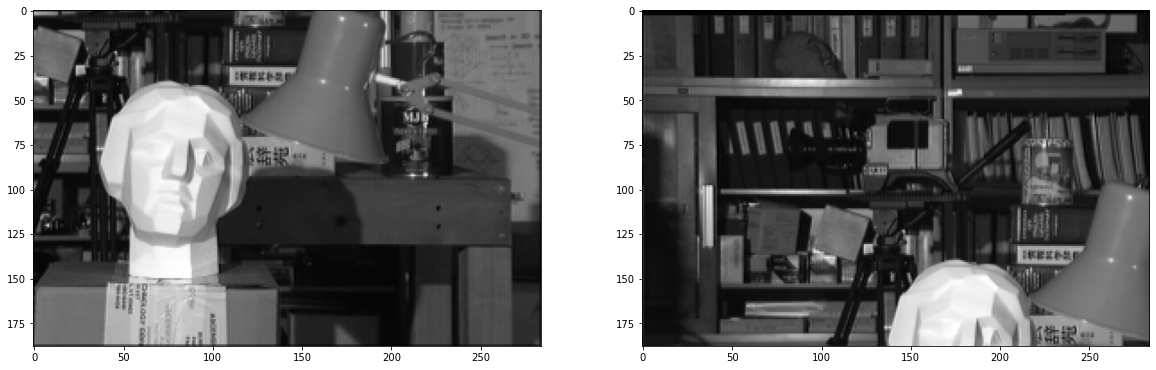

In [7]:

imgs: list[numpy.ndarray] = [
    img[100:, 100:],
    img[:-100, :-100]
]

figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(1, 2, 1)
matplotlib.pyplot.imshow(imgs[0], cmap='gray')

matplotlib.pyplot.subplot(1, 2, 2)
matplotlib.pyplot.imshow(imgs[1], cmap='gray')


img_features: list[ImageFeatures] = []

for img in imgs:
    img_features.append(ImageFeatures(img))

## Find corresponding

### Compute scores between differential invaraints

In [8]:
def symmetric_indices(i, j) -> tuple[int, int]:
    return (i, j) if j >= i else (j, i)

In [9]:
import eagle.points.descriptor.distance

# def get_window_bool(m: numpy.ndarray, p: numpy.ndarray, half_size: int) -> float:
    
#     p1 = p-half_size
#     p2 = p+half_size

#     win_bool = numpy.full(shape=(half_size*2+1, half_size*2+1), fill_value=False)

#     for i in range(max(0, p1[0]), max(0, p1[1])):
#         for j in range(min(m.shape[0], p2[0]), min(m.shape[0], p2[1])):
#             win_bool[i, j] = True

#     return win_bool


def compute_score(feature_1: ImageFeatures, feature_2: ImageFeatures, half_window_size: int = 0) -> numpy.ndarray:

    """ For each interest point from first feature, we compare interest point \n
    from second feature with the distance between differential invariant vector
    """
    
    nb_pts_1 = feature_1.interest_points.shape[0]
    nb_pts_2 = feature_2.interest_points.shape[0]

    score = numpy.zeros(shape=(nb_pts_1, nb_pts_2))


    for i in range(0, nb_pts_1):

        pt_i = feature_1.interest_points[i]
        vec_i = feature_1.differential_invariant[pt_i]

        # win_bool_i = get_window_bool(
        #     feature_1.interest_points,
        #     pt_i,
        #     half_window_size
        # ) 
        
        for j in range(0, nb_pts_2):

            pt_j = feature_2.interest_points[j]
            vec_j = feature_2.differential_invariant[pt_j]

            distance = 0
            distance = eagle.points.descriptor.distance.euclidean(vec_i, vec_j)
            score[i, j] = distance


            # if 0 < half_window_size :

            #     win_bool_j = get_window_bool(
            #         feature_2.interest_points,
            #         pt_j,
            #         half_window_size
            #     )

            #     p_window = numpy.transpose(numpy.array(numpy.where(win_bool_i * win_bool_j)))

            #     p_window_i = p_window + (pt_i-half_window_size)
            #     p_window_j = p_window + (pt_j-half_window_size)

            #     for k in range(0, p_window_i.shape[0]):
            #         vec_i = feature_1.differential_invariant[p_window_i[k][0], p_window_i[k][1]]
            #         vec_j = feature_1.differential_invariant[p_window_j[k][0], p_window_j[k][1]]
            #         distance += eagle.points.descriptor.distance.euclidean(vec_i, vec_j)

                

            #     # i_x1, i_y1 = pt_i-half_window_size
            #     # j_x1, j_y1 = pt_j-half_window_size

            #     # i_x2, i_y2 = pt_i+half_window_size
            #     # j_x2, j_y2 = pt_j+half_window_size

            #     # window_i = feature_1.differential_invariant[i_x1:j_x1, i_y1:j_y1]
            #     # window_j = feature_1.differential_invariant[i_x2:j_x2, i_y2:j_y2]

            #     # for i_window in range(inf1, sup1)

            #     # if window_i.shape == window_j.shape:

            #     #     for a in range(0, window_i.shape[0]):
            #     #         for b in range(0, window_i.shape[1]):
            #     #             vec_a, vec_b = window_i[a, b], window_j[a,]
            #     #             distance += eagle.points.descriptor.distance.euclidean(vec_a, vec_b)
                
            #     # else:
                
            #     #     distance = eagle.points.descriptor.distance.euclidean(vec_i, vec_j)

            # else:
                
            #     distance = eagle.points.descriptor.distance.euclidean(vec_i, vec_j)

    return score

In [10]:
nb_imgs = len(imgs)

# Sym Matrix : idx_i, idx_j = i, j if j <= i else j, i
scores = numpy.zeros(shape=(nb_imgs, nb_imgs), dtype=numpy.ndarray)


for i in range(0, nb_imgs):
    features_i = img_features[i]
    for j in range(0, nb_imgs):
        features_j = img_features[j]
        scores[i, j] = compute_score(features_i, features_j)        

### Find best corresponding

In [11]:
nb_imgs = len(imgs)

EPSILON_DISTANCE = 0.0


# Find j such as we have a maximum of corresponding
# for i
# corresp = list[tuple[int, numpy.ndarray]] = []

# corresp[i] index interest pts between i and j
corresp_img = numpy.empty(shape=nb_imgs, dtype=int)

corresp_pts = numpy.empty(shape=nb_imgs, dtype=numpy.ndarray)

for i in range(0, nb_imgs):

    best_pts: numpy.ndarray = corresp_pts[i]
    
    for j in range(0, nb_imgs):
    # for j in range(i+1, nb_imgs):
        # Problème :
        # score_ij est une matrice symetrique donc numpy.where peut renvoyer
        # de foix le même

        if i != j :
            
            score_ij: numpy.ndarray = scores[i, j]
            # print(score_ij.shape)
            tmp = numpy.transpose(numpy.array(numpy.where(score_ij <= EPSILON_DISTANCE)))
            # print(tmp.shape)

            if (best_pts is None) or (best_pts.shape[0] < tmp.shape[0]):
                best_pts = numpy.copy(tmp)
                corresp_img[i] = j
                corresp_pts[i] = best_pts

            

[[ 0  2]
 [ 1  3]
 [ 2  4]
 [ 3  5]
 [ 4  6]
 [ 8  7]
 [ 9  8]
 [10  9]
 [11 10]]
[ 0  1  2  3  4  8  9 10 11] [ 2  3  4  5  6  7  8  9 10]
[30 23] [130 123]
[34 22] [134 122]
[38  9] [138 109]
[ 38 128] [138 228]
[50 51] [150 151]
[ 80 135] [180 235]
[ 82 122] [182 222]
[ 82 130] [182 230]
[ 84 140] [184 240]


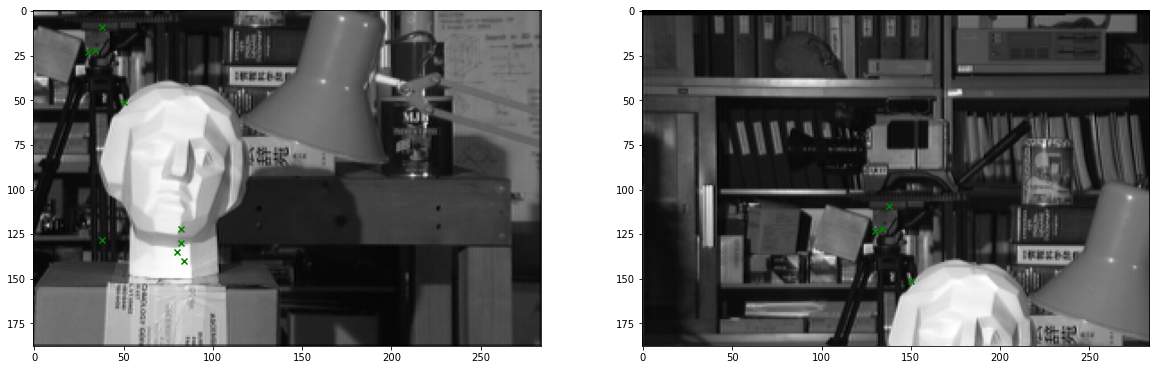

In [12]:
# print(corresp_img)
# print(corresp_pts.shape)
print(corresp_pts[0])

interest1 = img_features[0].interest_points
interest2 = img_features[0].interest_points
indices_pts1 = corresp_pts[0][:, 0]
indices_pts2 = corresp_pts[0][:, 1]

print(indices_pts1, indices_pts2)

points1 = img_features[0].interest_points[indices_pts1]
points2 = img_features[1].interest_points[indices_pts2]

# print(img_features[0].interest_points.shape, img_features[1].interest_points.shape)

for i in range(0, len(indices_pts1)):

    print(points1[i], points2[i])
# print(img_features[0].interest_points[0], img_features[0].interest_points[0])

# for i in range(0, len(indices_pts1)):

    # print(indices_pts1[i], indices_pts2[i])


# # print(points1, points2)

# # print(imgs[1].shape)

# # print(indices_pts1)
# # print(indices_pts2)

figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(1, 2, 1)
# matplotlib.pyplot.axis('off')
# # matplotlib.pyplot.title('I with points')
matplotlib.pyplot.scatter(points1[:, 0], points1[:, 1], marker='x', color="green")
_ = matplotlib.pyplot.imshow(imgs[0], cmap='gray')

matplotlib.pyplot.subplot(1, 2, 2)
# matplotlib.pyplot.axis('off')
# matplotlib.pyplot.title('I with points')
matplotlib.pyplot.scatter(points2[:, 0], points2[:, 1], marker='x', color="green")
_ = matplotlib.pyplot.imshow(imgs[1], cmap='gray')



## Compute homography

In [13]:
import eagle.utils

H = eagle.utils.homography_estimation(points1, points2, normalization=True)
print(H)

[[ 5.77350269e-01 -5.12786978e-15  5.77350269e+01]
 [ 2.76178031e-14  5.77350269e-01  5.77350269e+01]
 [ 1.07134614e-16 -3.42168942e-17  5.77350269e-01]]


In [14]:
pt = H @ numpy.array([34, 22, 1]).T
print(pt / pt[2])

[134. 122.   1.]


## Pixel transfert

In [15]:
def merge(img1: numpy.ndarray, img2: numpy.ndarray, homography: numpy.ndarray) -> numpy.ndarray:

    """
    Parameters:
        - img1: image
        - img2: image
        - homography : homography to tranfert pixel from img1 to img2
    """

    nb_rows, nb_cols = img1.shape

    corners = numpy.transpose(
        numpy.array(
            [
                numpy.array([0, 0, 1]),
                numpy.array([0, nb_cols, 1]),
                numpy.array([nb_rows, 0, 1]),
                numpy.array([nb_rows, nb_cols, 1])
            ]
        )
    )

    corners_out = homography @ corners

    for i in range(0, 4):
        corners_out[:, i] /= corners_out[2, i]

    row_min = numpy.min(corners_out[0:2, :][0, :])
    row_max = numpy.max(corners_out[0:2, :][0, :])
    col_min = numpy.min(corners_out[0:2, :][1, :])
    col_max = numpy.max(corners_out[0:2, :][1, :])

    nb_rows_out = nb_rows
    a = (nb_rows - 1) / (row_max - row_min)
    nb_cols_out = int(numpy.round(a * (col_max - col_min)))

    if nb_cols_out < nb_cols:
        nb_cols_out = nb_cols
        a = (nb_cols - 1) / (col_max - col_min)
        nb_rows_out = int(numpy.round(a * (row_max - row_min)))

    T = numpy.array(
        [
            [ a, 0, -a*row_min ],
            [ 0, a, -a*col_min],
            [ 0, 0, 1]
        ]
    )

    THinv = numpy.linalg.inv(T @ homography)

    result = numpy.zeros(shape=(nb_rows_out, nb_cols_out))


    print(result.shape, img1.shape)

    print(nb_rows_out, nb_cols_out)
   
    for i_out in range(0, nb_rows_out):

        for j_out in range(0, nb_cols_out):

            coord_out_homgeneous = numpy.array([ i_out, j_out, 1 ]).T

            coord_initiale = (THinv @ coord_out_homgeneous).T
            i = int(numpy.floor(coord_initiale[0] / coord_initiale[2]))
            j = int(numpy.floor(coord_initiale[1] / coord_initiale[2]))
            

            if ( (0 <= i) and (i < nb_rows) ) and ( (0 <= j) and (j < nb_cols) ) :
                result[i_out, j_out] = img1[i, j]

    return result









    # corner1 = homography @ up_left_homogeneous
    # corner1 /= corner1[2]
    # corner2 = homography @ up_right_homogeneous
    # corner2 /= corner2[2]
    # corner3 = homography @ down_left_homogeneous
    # corner3 /= corner3[2]
    # corner4 = homography @ down_right_homogeneous
    # corner4 /= corner4[2]

    





(187, 284) (188, 284)
187 284


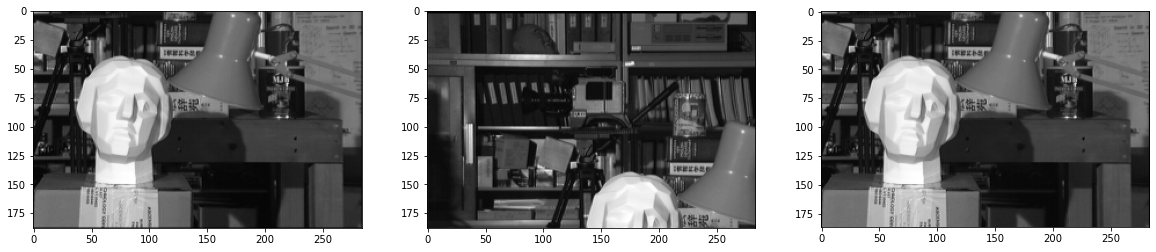

In [16]:
result = merge(imgs[0], imgs[1], H)
# print(result.shape)

figure = matplotlib.pyplot.figure(figsize=(20, 20))

matplotlib.pyplot.subplot(1, 3, 1)
# matplotlib.pyplot.axis('off')
# # matplotlib.pyplot.title('I with points')
# matplotlib.pyplot.scatter(points1[:, 0], points1[:, 1], marker='x', color="green")
_ = matplotlib.pyplot.imshow(imgs[0], cmap='gray')

matplotlib.pyplot.subplot(1, 3, 2)
# matplotlib.pyplot.axis('off')
# matplotlib.pyplot.title('I with points')
# matplotlib.pyplot.scatter(points2[:, 0], points2[:, 1], marker='x', color="green")
_ = matplotlib.pyplot.imshow(imgs[1], cmap='gray')


matplotlib.pyplot.subplot(1, 3, 3)
# matplotlib.pyplot.title('I with points')
# matplotlib.pyplot.scatter(points1[:, 0], points1[:, 1], marker='x', color="green")
_ = matplotlib.pyplot.imshow(result, cmap='gray')

# matplotlib.pyplot.subplot(1, 2, 2)
# # matplotlib.pyplot.axis('off')
# # matplotlib.pyplot.title('I with points')
# matplotlib.pyplot.scatter(points2[:, 0], points2[:, 1], marker='x', color="green")
# _ = matplotlib.pyplot.imshow(imgs[1], cmap='gray')